In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

ROOT_DIR = Path().resolve(strict=True).parent
DATA_DIR = f"{ROOT_DIR}/data/"

columns_to_skip = [
        "Shares (Basic)",
    "Sector",
    "Shares (Diluted)"
    ]

df = pd.read_csv(f"{DATA_DIR}/interim/more_fts.csv", index_col=0, usecols=lambda x: x not in columns_to_skip)

In [2]:
df.loc[df['Ticker'] == df['Ticker'].shift(periods=-1), 'next_year_revenue'] = df['Revenue'].shift(periods=-1)

train_df = df[(df["Fiscal Year"] <= 2017) & (df["Fiscal Year"] >= 2010)].dropna(subset = ['next_year_revenue'])
train_df = train_df.dropna(subset = ['next_year_revenue'])
test_df = df[(df["Fiscal Year"] <= 2019) & (df["Fiscal Year"] >= 2018)]
test_df = test_df.dropna(subset = ['next_year_revenue'])
train_df = train_df.drop(columns=["Fiscal Year", "Ticker"])
test_df = test_df.drop(columns=["Fiscal Year", "Ticker"])

y_train=train_df['next_year_revenue']
X_train=train_df.drop(['next_year_revenue'],axis=1)
y_test=test_df['next_year_revenue']
X_test=test_df.drop(['next_year_revenue'],axis=1)

In [3]:
import xgboost
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lars, Ridge, SGDRegressor, TheilSenRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR

In [4]:
xg_classifier = xgboost.XGBRegressor()
theil_sen_reg = TheilSenRegressor(random_state=0)
lars_reg = Lars(n_nonzero_coefs=1)
sdg_reg = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3))
ridge_reg = Ridge(alpha=1.0)
random_forrest_reg = RandomForestRegressor(max_depth=2, random_state=0)
poly_regs= PolynomialFeatures(degree= 2)
lin_reg =LinearRegression()
dec_tre_reg = DecisionTreeRegressor(max_depth=2)
svr_reg = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))

In [5]:
random_forrest_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)
sdg_reg.fit(X_train, y_train)
lars_reg.fit(X_train, y_train)
theil_sen_reg.fit(X_train, y_train)
xg_classifier.fit(X_train, y_train)
dec_tre_reg.fit(X_train, y_train)
lin_reg_poly = lin_reg.fit(poly_regs.fit_transform(X_train), y_train)
lin_reg.fit(X_train, y_train)
svr_reg.fit(X_train, y_train)

/home/lucas/Dev/earnings_predictions/epvenv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.10217e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/lucas/Dev/earnings_predictions/epvenv/lib/python3.10/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.2))])

In [6]:
xg_pred = xg_classifier.predict(X_test)
dec_tre_reg_pred = dec_tre_reg.predict(X_test)
lin_reg_pred = lin_reg.predict(X_test)
lin_reg_poly_pred = lin_reg_poly.predict(X_test)
random_forrest_reg_pred = random_forrest_reg.predict(X_test)
ridge_reg_pred = ridge_reg.predict(X_test)
sdg_reg_pred = sdg_reg.predict(X_test)
lars_reg_pred = lars_reg.predict(X_test)
svr_reg_pred = svr_reg.predict(X_test)
theil_sen_reg_pred = theil_sen_reg.predict(X_test)

In [7]:
from sklearn.metrics import mean_squared_error, r2_score, classification_report, mean_absolute_error
from statistics import mean

In [22]:
results_dict = {
    "xg_classifier": {"model":xg_classifier,"pred": xg_pred,},
    "dec_tre_reg": {"model":dec_tre_reg,"pred": dec_tre_reg_pred,},
    "lin_reg": {"model":lin_reg,"pred": lin_reg_pred,},
    "lin_reg_poly": {"model":lin_reg_poly,"pred": lin_reg_poly_pred,},
    "random_forrest_reg": {"model":random_forrest_reg,"pred": random_forrest_reg_pred,},
    "ridge_reg": {"model":ridge_reg,"pred": ridge_reg_pred,},
    "sdg_reg": {"model":sdg_reg,"pred": sdg_reg_pred,},
    "lars_reg": {"model":lars_reg,"pred": lars_reg_pred,},
    "svr_reg": {"model":svr_reg,"pred": svr_reg_pred,},
    "theil_sen_reg": {"model":theil_sen_reg,"pred": theil_sen_reg_pred,},
}

def calculate_bests(results_dict=results_dict):
    best_calculation = ["score", "r2_score", "mean_squared_error", "mean_absolute_error"]

    for key, value in results_dict.items():
        model = results_dict[key]["model"]
        pred = results_dict[key]["pred"]
        results_dict[key] = {
            "score": model.score(X_train, y_train),
            "r2_score": r2_score(y_test, pred),
            "mean_squared_error": mean_squared_error(y_test, pred),
            "mean_absolute_error": mean_absolute_error(y_test, pred)
        }

    best_score = []
    best_r2 = []
    best_mse = []
    best_mae = []
    for key, value in results_dict.items():
        score = results_dict[key]["score"]
        r2 = results_dict[key]["r2_score"]
        mse = results_dict[key]["mean_squared_error"]
        mae = results_dict[key]["mean_absolute_error"]
        best_score.append(score)
        best_r2.append(r2)
        best_mse.append(mse)

    best_score.sort(reverse=True)
    best_r2.sort(reverse=True)
    best_mse.sort(reverse=True)

    for key, value in results_dict.items():
        score = results_dict[key]["score"]
        r2 = results_dict[key]["r2_score"]
        mse = results_dict[key]["mean_squared_error"]

        best_score_index = best_score.index(score) + 1
        best_r2_index = best_r2.index(r2) + 1
        best_mse_index = best_mse.index(mse) + 1
        results_dict[key]["score_position"] = best_score_index
        results_dict[key]["r2_score_position"] = best_r2_index
        results_dict[key]["mean_squared_error_position"] = best_mse_index
        results_dict[key]["average_position"] = mean([best_score_index, best_r2_index, best_mse_index])

In [ ]:
calculate_bests(results_dict=results_dict)

In [23]:
from src.visualization.visualize import best_and_average_plot, r2_and_score_plot, mse_best_comp_plot

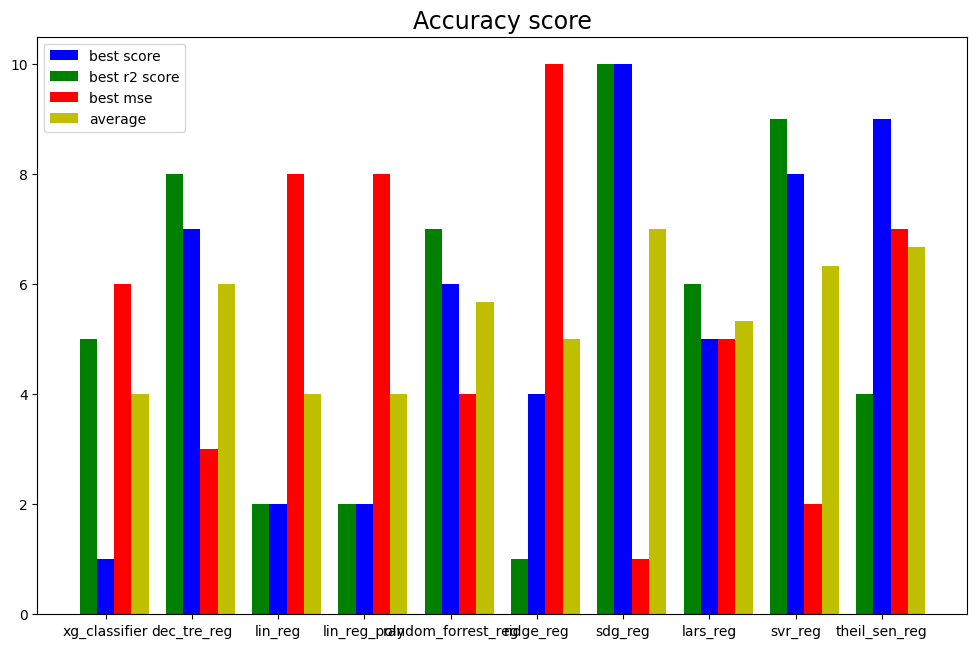

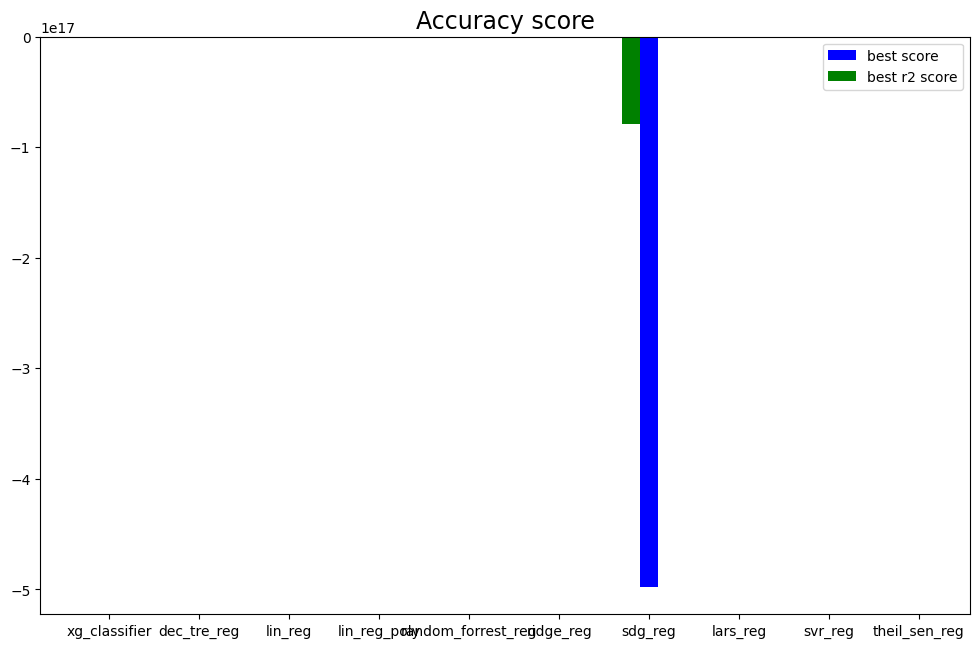

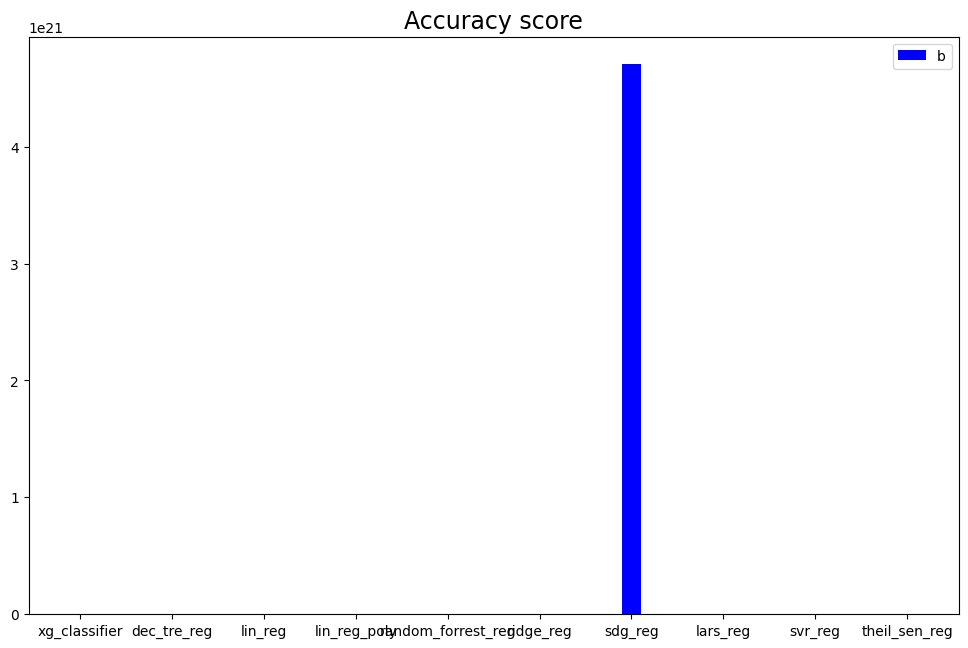

In [24]:
best_and_average_plot(results_dict=results_dict)
r2_and_score_plot(results_dict=results_dict)
mse_best_comp_plot(results_dict=results_dict)

In [25]:
results_dict.pop("sdg_reg")
results_dict.pop("theil_sen_reg")
# results_dict.pop("sdg_reg")

{'score': -269.96300957289725,
 'r2_score': 0.9903487123130613,
 'mean_squared_error': 572.5989819544758,
 'score_position': 9,
 'r2_score_position': 4,
 'mean_squared_error_position': 7,
 'average_position': 6.666666666666667}

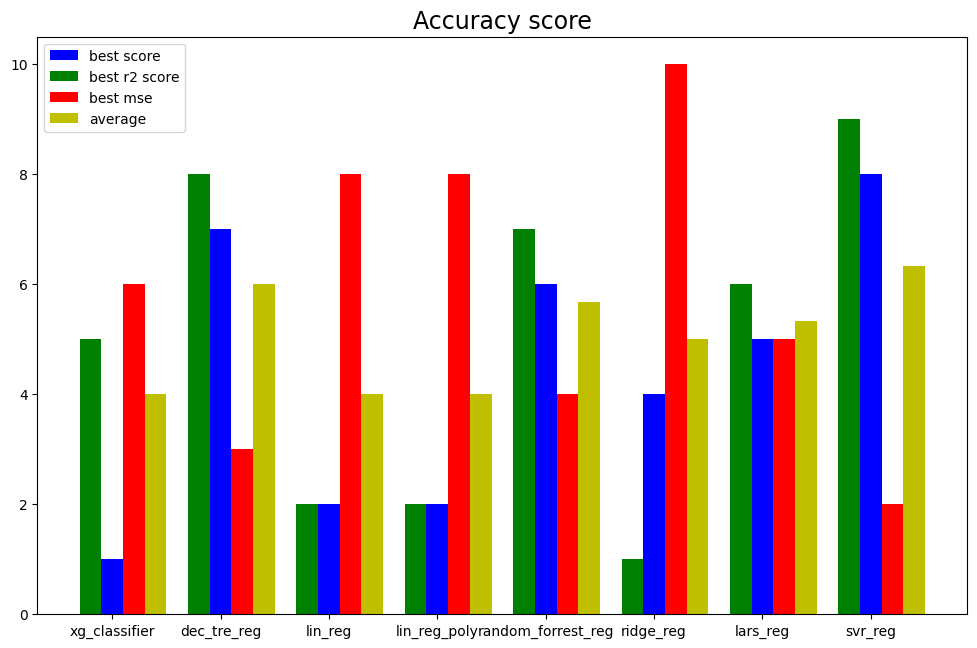

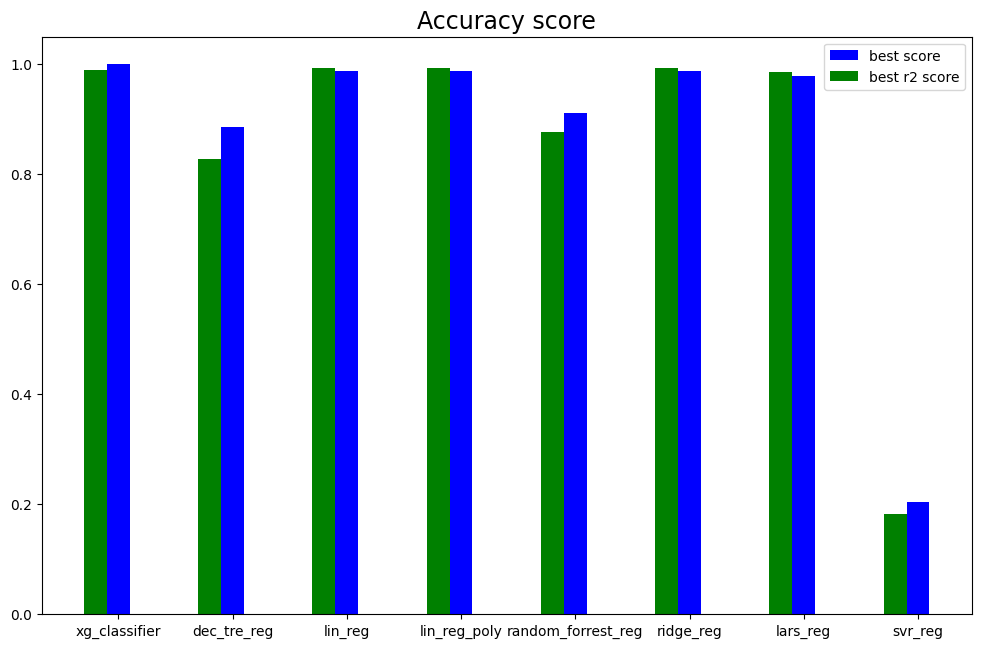

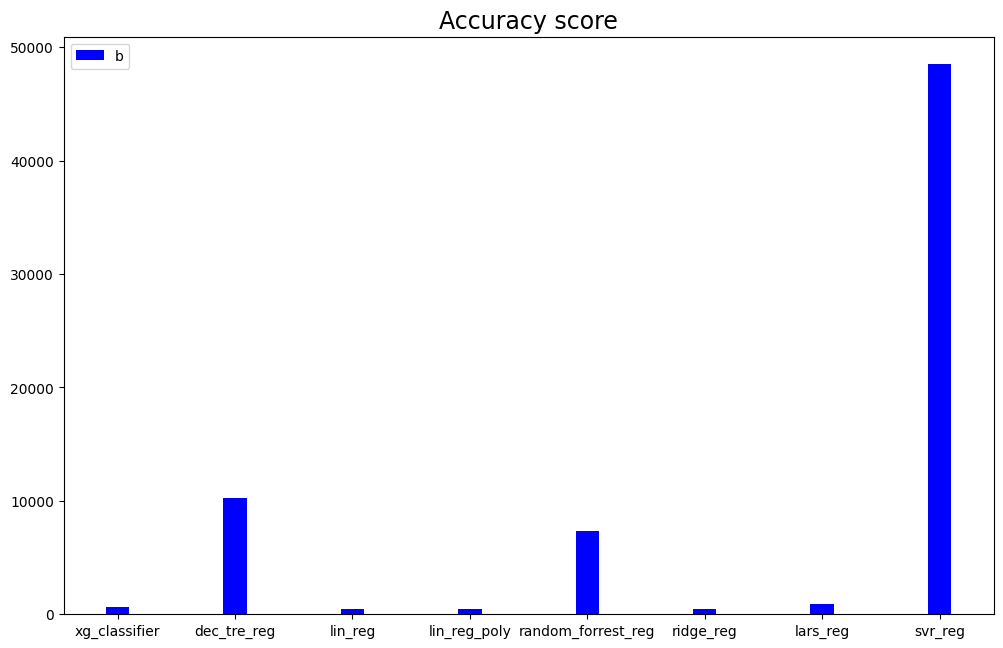

In [26]:
best_and_average_plot(results_dict=results_dict)
r2_and_score_plot(results_dict=results_dict)
mse_best_comp_plot(results_dict=results_dict)